In [6]:
%pip install torch
%pip install scikit-learn
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 43.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 62.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
Note: you may need to restart the kernel t

In [7]:
# Import all the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
# Base model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        return x

base_model = BaseModel().to(device)

# Head for softmax classification
class SoftmaxHead(nn.Module):
    def __init__(self):
        super(SoftmaxHead, self).__init__()
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        return self.fc(x)

softmax_head = SoftmaxHead().to(device)

# Implementation of Supervised Contrastive Loss
def supcon_loss(features, labels, temperature):
    features = nn.functional.normalize(features, p=2, dim=1)
    batch_size = features.shape[0]
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)
    
    # Compute similarity
    contrast_feature = torch.div(features, temperature)
    logits = torch.matmul(contrast_feature, contrast_feature.T)
    logits -= torch.eye(batch_size).to(device) * 1e12
    
    # Compute log_prob
    exp_logits = torch.exp(logits) * mask
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
    
    # Compute mean log-likelihood for positive
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    
    # Loss
    loss = -mean_log_prob_pos
    loss = loss.mean()
    
    return loss

# Training function for supervised contrastive learning
def train_contrastive(model, dataloader, optimizer, temperature):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        features = model(data)
        loss = supcon_loss(features, target, temperature)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Training function for softmax classification
def train_softmax(model, head, dataloader, optimizer, criterion):
    model.eval()
    head.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            features = model(data)
        output = head(features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# Visualize with t-SNE
def visualize_tsne(features, labels, title='t-SNE'):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

supcon_loss = SupConLoss().to(device)

# Softmax loss
criterion = nn.CrossEntropyLoss().to(device)

# Optimizers
optimizer_base = optim.Adam(base_model.parameters(), lr=0.001)
optimizer_softmax = optim.Adam(softmax_head.parameters(), lr=0.001)

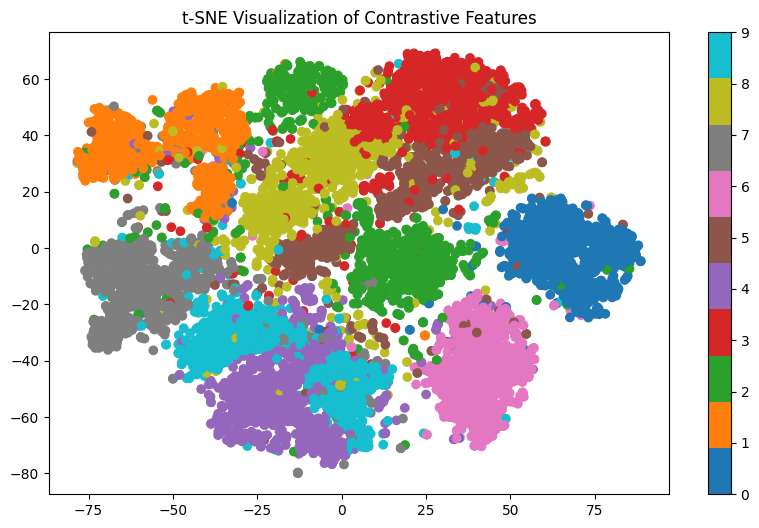

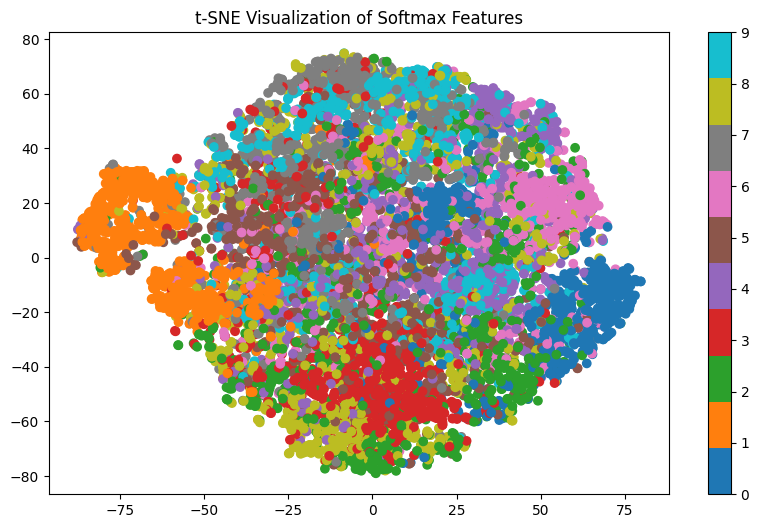

In [21]:
# Set the model to evaluation mode and deactivate gradient calculations
base_model.eval()
softmax_head.eval()
features_contrastive = []
features_softmax = []
labels_list = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        feature = base_model(data)
        output = softmax_head(feature)

        # Store features and labels for visualization
        features_contrastive.append(feature.cpu().numpy())
        features_softmax.append(output.cpu().numpy())
        labels_list.append(target.numpy())

# Concatenate all collected features and labels
features_contrastive = np.concatenate(features_contrastive)
features_softmax = np.concatenate(features_softmax)
labels = np.concatenate(labels_list)

# Function to run t-SNE and plot the result
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Visualize t-SNE for Contrastive Features
visualize_tsne(features_contrastive, labels, 't-SNE Visualization of Contrastive Features')

# Visualize t-SNE for Softmax Features
visualize_tsne(features_softmax, labels, 't-SNE Visualization of Softmax Features')

Clusters created using contrastive features are more distinct and separated, suggesting that it is has better performance on classification tasks compared to soft-max.